In [56]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

In [57]:
def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [58]:
def get_varbs(kind, case, fname, meshmaskname, time_s):
    
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    with scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vovecrtz = dsW.variables['vovecrtz'][time_s, :, y, x]
        vosaline = dsT.variables['vosaline'][time_s, :, y, x]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        
    print(kind, time_s)
        
    return vovecrtz, vosaline, e1t, e2t

In [59]:
def plot_surface_snapshot(time_s, fs_numb):
    
    kind = 'ideal'
    
    if kind == 'ideal':
        x_left, y_bottom = 205.822543591543,24.85159075988878
        inds = [90, 10]
        mid = 306
    elif kind == 'real':
        x_left, y_bottom = 296.29431501679437, 24.85159075988878
        inds = [130, 10]
        mid = 400
        
    vm = 1.2
    
    salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694
    salt = salt_ATW_SA
    
    fname = '1_MCKNZ_1h_20170101_201701*'
    meshmaskname = '1_mesh_mask.nc'
    
    case = 'base'
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

    vovecrtz, vosaline, e1t, e2t = get_varbs(kind, case, fname, meshmaskname, time_s)
    w_surface = get_varb_surf(vosaline, salt, vovecrtz) * 1000
    
    x_shift, y_shift = x_left+e1t, y_bottom+e2t
    
    cmap = cmo.cm.balance
    cmap.set_bad('#8b7765')
       
    p = ax.pcolormesh(x_shift, y_shift, w_surface, vmin=-vm, vmax=vm, cmap=cmo.cm.balance)
    
    min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    ax.set_aspect(aspect='equal')
    ax.set_title('Hour '+str(time_s+1), fontsize=fs_str)
    
#     ind_y = 180
#     ind_y_mid = ind_y + (max_y-ind_y)*0.5
#     ax.add_patch(patches.Rectangle((min_x, ind_y),(max_y-ind_y),(max_y-ind_y),
#                                    fc='w', ec='k', lw=1.5, alpha=1, zorder=8))
#     ax.annotate(lab, xy=(min_x+(max_y-ind_y)*0.5, ind_y_mid),
#                 fontsize=fs_str, weight='bold', va='center', ha='center', zorder=9)
    
    return ax, p

ideal 17
ideal 23
ideal 29
ideal 35
ideal 41
ideal 47
ideal 53
ideal 59
ideal 65
ideal 71
ideal 77
ideal 83


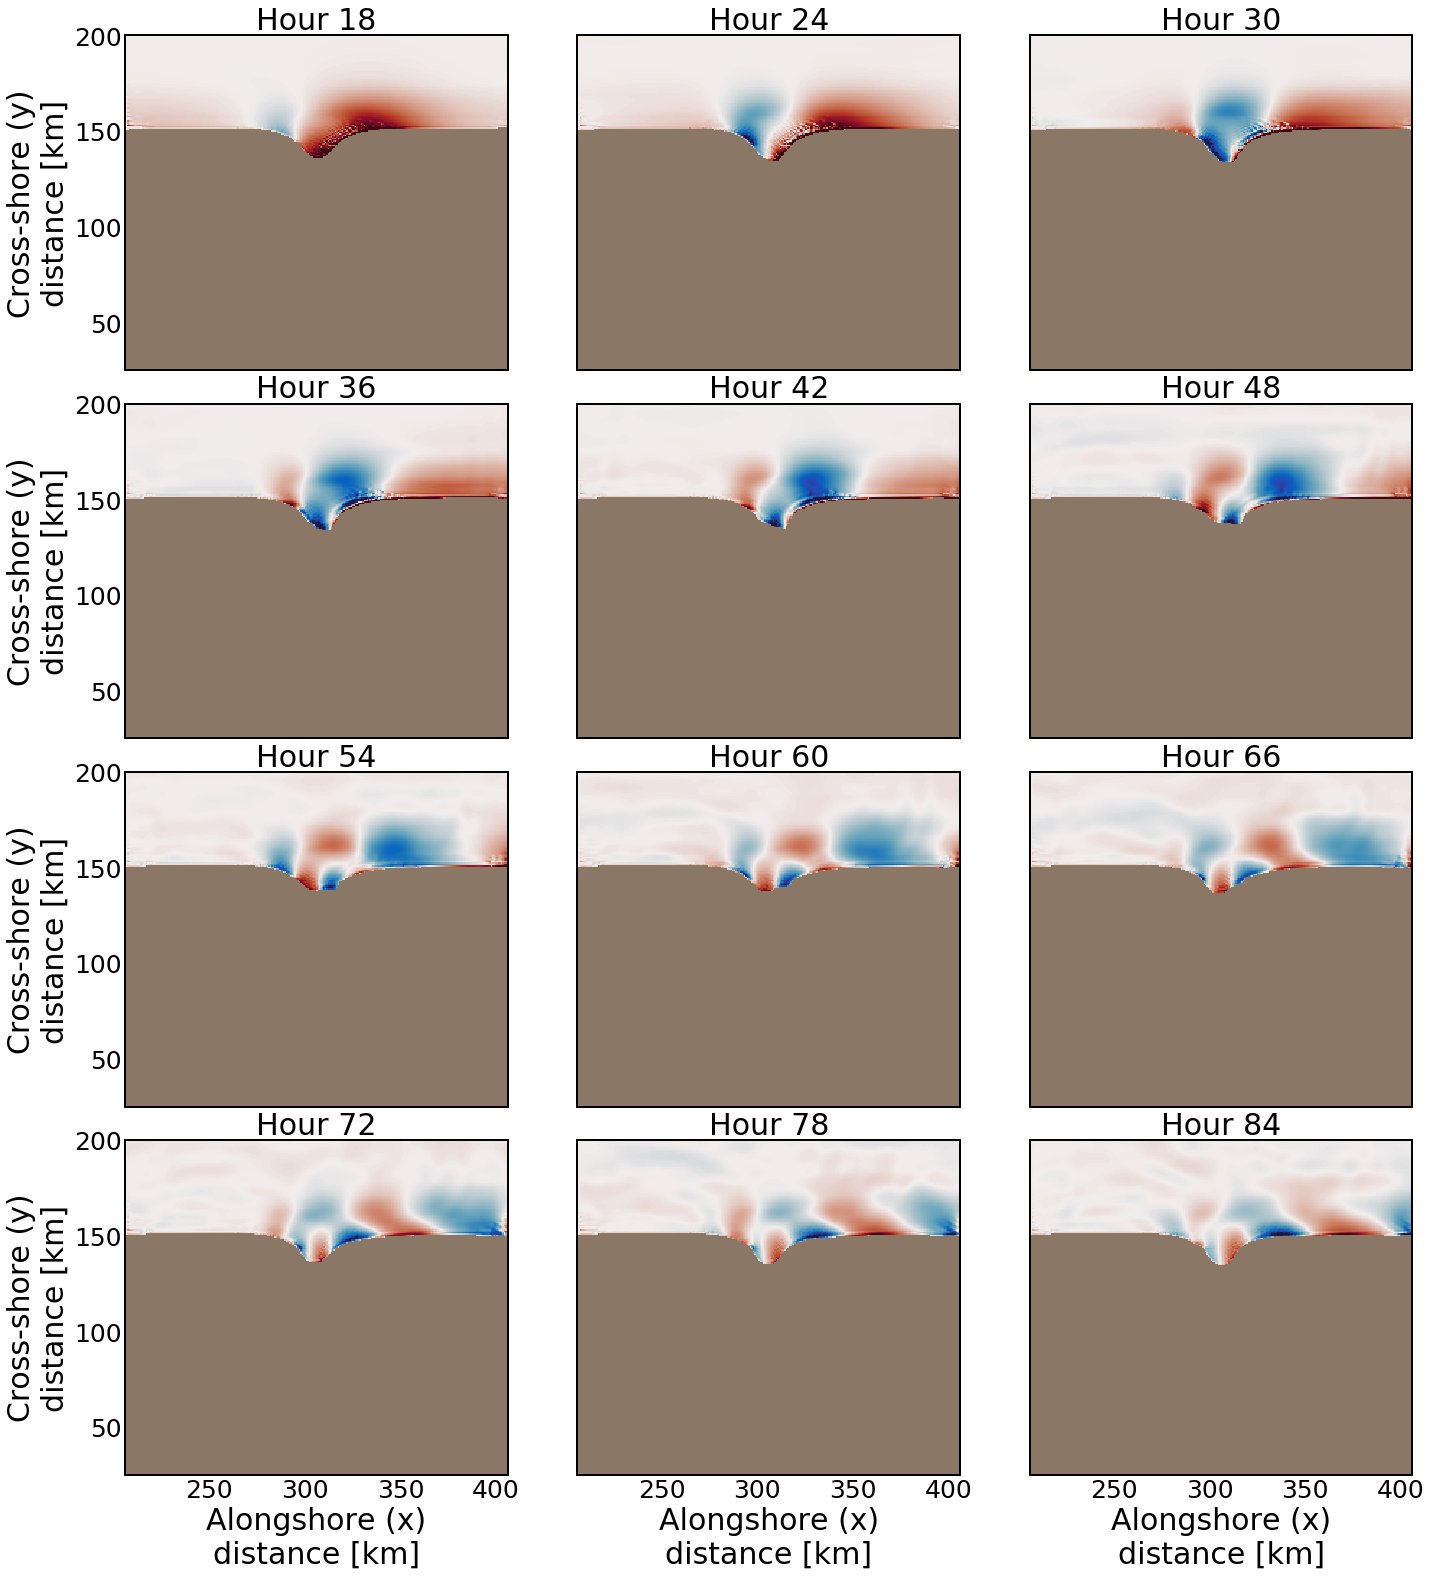

In [60]:
time_all = np.arange(17, 86, 6)

fs_numb, fs_str = 25, 30
fig, axes =  plt.subplots(4, 3, figsize=(20, 22))
for ax, time_s in zip(axes.flatten(), time_all):
    ax, p = plot_surface_snapshot(time_s, fs_numb)
    ax.yaxis.set_ticks(np.arange(50, 250, 50))
    ticklabs = np.arange(250,450,50)
    ax.xaxis.set_ticks(ticklabs)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
for n in ([1, 2, 4, 5, 7, 8, 10, 11]):
    axes.flatten()[n].yaxis.set_tick_params(labelbottom=False)

for n in ([0, 1, 2, 3, 4, 5, 6, 7, 8]):
    axes.flatten()[n].xaxis.set_tick_params(labelbottom=False)

for n in ([9, 10, 11]):
    axes.flatten()[n].set_xlabel('Alongshore (x)\ndistance [km]', fontsize=fs_str)

for n in ([0, 3, 6, 9]):
    axes.flatten()[n].set_ylabel('Cross-shore (y)\ndistance [km]', fontsize=fs_str)
    
fig.tight_layout()
fig.patch.set_facecolor('white')    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig.savefig('./fig_propagation_AW.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())